In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth



PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3p06avlc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3p06avlc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=9060e61c6a5c073002e21f3fdd4074bd487528dd0615a4b3ce3fb438c3bda253
  Stored in directory: /tmp/pip-ephem-wheel-cache-2hmbytil/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-12-15 17:37:13--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import os

files = os.listdir("/content/drive/MyDrive/ml_masters/original_data")
len(files)

2378

In [46]:
img_names = set(f.split(".")[0] for f in files)
len(img_names)

1272

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def getLabels(labelPath):
    with open(labelPath) as f:
        # Preparing list for annotation of BB (bounding boxes)
        labels = []
        for line in f:
            labels += [line.rstrip()]

    return labels

def readLabelBB(labels, w, h):
    parsedLabels = []
    for i in range(len(labels)):
        bb_current = labels[i].split()
        objClass = bb_current[0]
        x_center, y_center = int(float(bb_current[1]) * w), int(float(bb_current[2]) * h)
        box_width, box_height = int(float(bb_current[3]) * w), int(float(bb_current[4]) * h)
        parsedLabels.append((x_center, y_center, box_width, box_height))
    return parsedLabels, objClass
def getConvertedBoxes(labels, image_width, image_height):
    converted_boxes = []
    class_ids = []
    for i in range(len(labels)):
        bb_current = labels[i].split()
        class_id = int(bb_current[0])
        x_center, y_center = float(bb_current[1]), float(bb_current[2])
        box_width, box_height = float(bb_current[3]), float(bb_current[4])


        x0 = int((x_center - box_width / 2) * image_width)
        y0 = int((y_center - box_height / 2) * image_height)
        x1 = int((x_center + box_width / 2) * image_width)
        y1 = int((y_center + box_height / 2) * image_height)
        class_ids.append(class_id)
        converted_boxes.append([x0, y0, x1, y1])
    return  class_ids, converted_boxes

In [53]:


from PIL import Image

original_file_path = "/content/drive/MyDrive/ml_masters/original_data"
destination = "/content/drive/MyDrive/ml_masters/segm_data"


def convert_bbox_to_segmentation_mask(name, plot=False):
    labels = getLabels(original_file_path + f'/{name}.txt')
    image = cv2.imread(original_file_path + f'/{name}.jpg', cv2.IMREAD_COLOR)
    predictor.set_image(image)

    h, w = image.shape[:2]
    class_ids, bounding_boxes = getConvertedBoxes(labels, w, h)
    if plot:
      raw_image = Image.open(original_file_path + f'/{name}.jpg').convert("RGB")
      show_boxes_on_image(raw_image, bounding_boxes)
    input_boxes = torch.tensor(bounding_boxes, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    return class_ids, masks, (h, w)



In [38]:
_, mask, _ = convert_bbox_to_segmentation_mask("img5")
mask.shape

torch.Size([2, 1, 195, 259])

In [39]:
def show_masks_on_image(raw_image, masks):
    if len(masks.shape) == 4:
      masks = masks.squeeze(0)

    nb_predictions = max(len(masks), 2)
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, mask in enumerate(masks):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}")
      axes[i].axis("off")
    plt.show()

In [35]:
mask.squeeze(0)[0]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

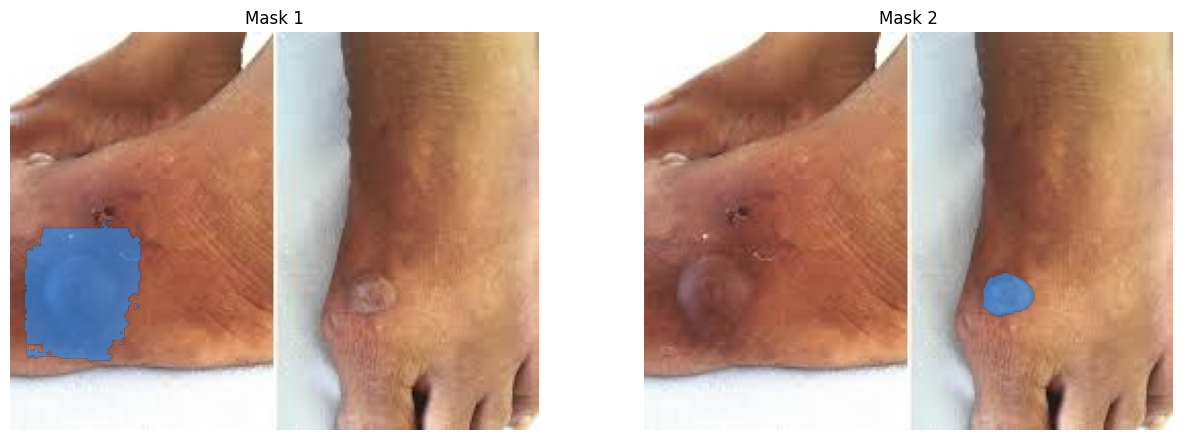

In [41]:
show_masks_on_image(Image.open(original_file_path + f'/img5.jpg'), mask)

In [89]:
parsed_img_names = [n for n in img_names if os.path.exists(original_file_path + f"/{n}.jpg") and os.path.exists(original_file_path + f"/{n}.txt")]
len(parsed_img_names)

1104

In [90]:
import tqdm

if not os.path.exists(destination):
    os.makedirs(destination)

data = {}
for name in tqdm.tqdm(parsed_img_names):
  class_ids, masks, (h, w) = convert_bbox_to_segmentation_mask(name)

  if len(mask) < 0:
    continue
  mask = masks[0].squeeze().cpu().numpy().astype(np.uint8)
  for i, submask in enumerate(masks):
      try:
         binary_mask = submask.squeeze().cpu().numpy().astype(np.uint8)
         mask[binary_mask] =  class_ids[i]
      except Exception as e:
          print(e)
          continue
  data[name] = mask

data

 100%|███████▉| 1104/1104 [46:33<0:00,  2.43s/it]


In [73]:
torch.save(data, "/content/drive/MyDrive/ml_masters/segm_data.pth")

In [75]:
img_names = list(img_names)

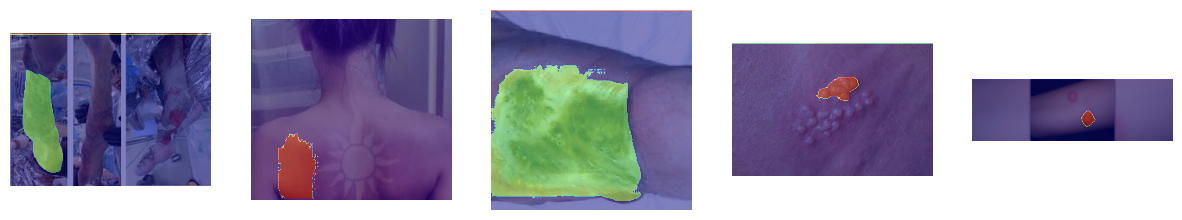

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def overlay_image_and_mask(image_path, mask, ax):
    image = Image.open(image_path)

    image_array = np.array(image)
    mask_array = np.array(mask)

    ax.imshow(image_array)
    ax.imshow(mask_array, cmap='jet', alpha=0.5)
    ax.axis('off')

image_paths = list(data.keys())[20:25]

num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    overlay_image_and_mask(original_file_path + f"/{image_paths[i]}.jpg", data[image_paths[i]], axes[i])

plt.show()

Segmenation model training

In [97]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3


model = UNet(in_channels=3, out_channels=1)

In [100]:
imgs = [Image.open(original_file_path + f"/{f}.jpg") for f in data.keys()]

In [101]:
combined_data = list(zip(imgs, data.values()))

In [102]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, mask = self.data[idx]

        image = Image(img_name).convert('RGB')
        mask = Image(mask).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = CustomDataset(data=combined_data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Epoch 1/108, Train Loss: 310.3999, Val Loss: 321.0000
Epoch 2/108, Train Loss: 302.2598, Val Loss: 316.5684
Epoch 3/108, Train Loss: 293.8897, Val Loss: 310.8895
Epoch 4/108, Train Loss: 288.6392, Val Loss: 305.3234
Epoch 5/108, Train Loss: 279.3249, Val Loss: 303.5354
Epoch 6/108, Train Loss: 281.7555, Val Loss: 298.1640
Epoch 7/108, Train Loss: 271.3859, Val Loss: 294.5532
Epoch 8/108, Train Loss: 266.4575, Val Loss: 287.0996
Epoch 9/108, Train Loss: 263.4810, Val Loss: 282.0462
Epoch 10/108, Train Loss: 258.4350, Val Loss: 280.6164
Epoch 11/108, Train Loss: 245.0890, Val Loss: 272.6986
Epoch 12/108, Train Loss: 239.1665, Val Loss: 272.5095
Epoch 13/108, Train Loss: 236.8658, Val Loss: 265.8603
Epoch 14/108, Train Loss: 228.3220, Val Loss: 262.3545
Epoch 15/108, Train Loss: 214.3491, Val Loss: 260.2633
Epoch 16/108, Train Loss: 201.4751, Val Loss: 252.0534
Epoch 17/108, Train Loss: 222.3945, Val Loss: 254.3211
Epoch 18/108, Train Loss: 188.1754, Val Loss: 239.5641
Epoch 19/108, Train

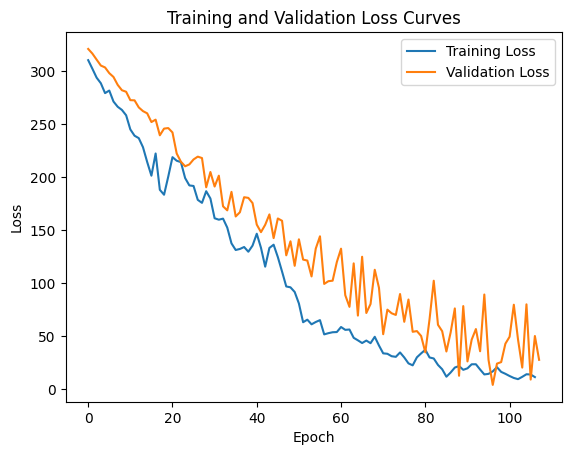

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


model = UNet(in_channels=3, out_channels=1).to("cuda")


num_epochs = 10
learning_rate = 0.001
batch_size = 8

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


model = UNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader):
        inputs, masks = batch.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)


    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs, masks = batch.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            running_val_loss += loss.item()

    average_val_loss = running_val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")


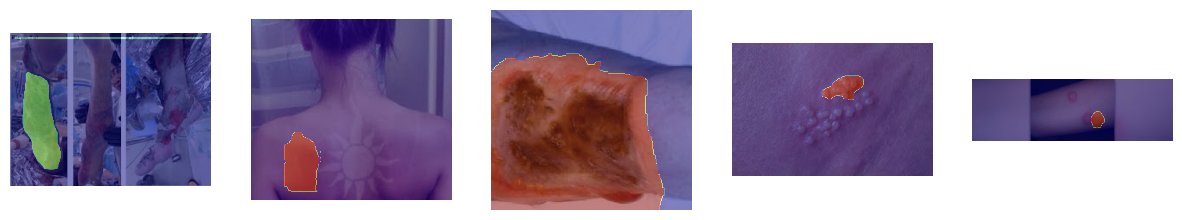

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from copy import deepcopy
from torchvision.transforms.functional import resize

def resize_mask_to_image(image, mask):
    image_size = image.size
    resized_mask = resize(mask, image_size)
    return resized_mask


image_paths = list(data.keys())[20:25]
images = [original_file_path + f"/{image_paths[i]}.jpg" for i in range(num_images)]
masks = [resize_mask_to_image(model(transform(Image.open(img))), Image.open(img)) for img in images]


num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for img, masks in range(zip(images, masks)):
    overlay_image_and_mask(img, masks, axes[i])

plt.show()